# Predict Lodging Price - a Case Study 
Context: This was a case study exercise I conducted for several companies. I have scrubbed the data, modified the attribute names, to redact any actual information. 

NYC Lodgings is an online booking service for New York lodging. It wants to estimate a fair price of lodgings dependent on some features. Using machine learning, predict lodging prices and identify how different features influence the prediction.

#### Files
```
train.csv
test.csv
sample_output.csv
 ```

### Problem

Perform an analysis of the given data to determine how different features are related to price. Build a machine learning model that can predict the price. For each record in the test set (test.csv), predict the value of the price variable . Submit a CSV file with a header row plus each of the test entries, each on its own line. The file (submissions.csv) should have exactly 2 columns:

```
id
price
```

### Deliverables

Well commented Jupyter notebook
“submissions.csv”
 
Explore the data, make visualizations, and generate new features if required. Make appropriate plots, annotate the notebook with markdowns and explain necessary inferences.

#### Other Criteria Considered
* Code quality and clarity such as well formated and commented functions.
* Algorithm sophistication.
 

### Evaluation Metric
The metric used for evaluating the performance of Mean Absolute Percent Error.

MAPE = MAPE is the mean of the absolute percentage errors of forecasts.


## Install packages for the notebook using pip or pip3 and requirements.txt

In [ ]:
# If you'd like to install packages that aren't installed by default, uncomment the last two lines of this cell and replace <package list> with a list of your packages.
# This will ensure your notebook has all the dependencies and works everywhere

#import sys
#!{sys.executable} -m pip install <package list>

#!pip install -r requirements.txt
#!pip3 install -r requirements.txt

In [18]:
#Libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import pickle
import time
import  warnings
from datetime import date
from datetime import datetime
from scipy import stats
from sklearn import preprocessing
from sklearn import datasets, linear_model, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, precision_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import k_means_constrained 
from k_means_constrained import KMeansConstrained
import folium


import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

import seaborn as sns
warnings.simplefilter('ignore')

pd.set_option("display.max_columns", 99)

## Data Description

Column | Description
:---|:---
`District` | The name of the district 
`Neighborhood` | The name of the neighborhood area
`PropertyType` | The type of the property
`CancellationPolicy` | The easiness of cancelling the reservation
`Accomodates` | The number of guests the lodging can handle 
`RoomType` | The type of the lodging.
`Bathrooms` | The number of bathrooms
`Bedrooms` | The number of bedrooms
`CleaningFee` | The fee charged to clean the room after ending the accommodation
`Latitude` | Latitude of the property
`Longitude` | Longitude of the property
`ReviewRating`|  The average score of reviews
`Price` | The lodging price per night (Target Variable)

## Data Wrangling & Visualization
Here is what we're going to do: we're going to explore the training data that we have by observing what variables are included, if there is any empty data, and observe the distribution of data for each of these variables. The idea is that we may see different relationships between Price and the variables that are included in the training set. Let's explore below:

In [3]:
# Dataset is already loaded below
data = pd.read_csv("data/train.csv")

The lodging data is from NYC, and we have various bits of info available to us such as the District, Neighborhood, PropertyType, RoomType, Bathrooms, and Bedrooms. We are also given the geographical coordinates of the lodging, as well as their cancellation policy, and review rating. If we had access to more data, I would have wanted to see how many reviews these lodgings have had, as the Review Rating can be inflated from a low number of reviews.

In [ ]:
data.head()

,ID,District,Neighborhood,PropertyType,CancellationPolicy,Accommodates,RoomType,Bathrooms,Bedrooms,CleaningFee,Latitude,Longitude,ReviewRating,Price
0,698375,Manhattan,NoHo,Apartment,strict,4,Entire home/apt,1.0,1.0,75.0,40.727692,-73.991930,93.0,300.0
1,3041785,Manhattan,East Village,Loft,strict,7,Entire home/apt,2.0,3.0,100.0,40.728888,-73.988532,85.0,249.0
2,17222167,Manhattan,Harlem,Apartment,strict,2,Private room,1.0,1.0,17.0,40.820182,-73.946286,100.0,48.0
3,10366570,Manhattan,Harlem,Apartment,moderate,4,Entire home/apt,1.0,1.0,45.0,40.817061,-73.936558,94.0,125.0
4,10838084,Manhattan,Washington Heights,Apartment,strict,2,Private room,1.0,1.0,30.0,40.856122,-73.930240,92.0,45.0


In [ ]:
#Explore columns
data.columns

Index(['ID', 'District', 'Neighborhood', 'PropertyType', 'CancellationPolicy',
       'Accommodates', 'RoomType', 'Bathrooms', 'Bedrooms', 'CleaningFee',
       'Latitude', 'Longitude', 'ReviewRating', 'Price'],
      dtype='object')

In [ ]:
#Description_1
data.describe()

,ID,Accommodates,Bathrooms,Bedrooms,CleaningFee,Latitude,Longitude,ReviewRating,Price
count,6.000000e+03,6000.000000,5969.000000,5992.000000,4561.000000,6000.000000,6000.000000,6000.000000,5974.000000
mean,9.167888e+06,2.893500,1.093483,1.095628,67.502960,40.764430,-73.973469,92.788000,164.486441
std,5.546844e+06,1.756134,0.351017,0.673336,46.316456,0.039392,0.023076,8.691048,116.320182
min,2.515000e+03,1.000000,0.000000,0.000000,0.000000,40.586936,-74.018104,20.000000,10.000000
25%,4.294022e+06,2.000000,1.000000,1.000000,35.000000,40.729483,-73.991534,90.000000,90.000000
50%,9.364843e+06,2.000000,1.000000,1.000000,60.000000,40.760914,-73.980148,95.000000,135.000000
75%,1.412299e+07,4.000000,1.000000,1.000000,90.000000,40.796176,-73.952241,100.000000,200.000000
max,1.849140e+07,16.000000,6.000000,6.000000,500.000000,40.876831,-73.798061,100.000000,999.000000


In [ ]:
#Description_2
data.describe(exclude=np.number)

,District,Neighborhood,PropertyType,CancellationPolicy,RoomType
count,6000,6000,6000,6000,6000
unique,4,65,18,3,3
top,Manhattan,Harlem,Apartment,strict,Entire home/apt
freq,5890,797,5640,3264,3459


Let's check the data types of the attributes below, and their non-null count. We know there are 4201 rows, and it seems like each attribute is populated, with no null values. The categorical variables that we have are District, Neighborhood, PropertyType, CancellationPolicy and RoomType. 

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4201 entries, 0 to 4200
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  4201 non-null   int64  
 1   District            4201 non-null   object 
 2   Neighborhood        4201 non-null   object 
 3   PropertyType        4201 non-null   object 
 4   CancellationPolicy  4201 non-null   object 
 5   Accommodates        4201 non-null   int64  
 6   RoomType            4201 non-null   object 
 7   Bathrooms           4201 non-null   float64
 8   Bedrooms            4201 non-null   float64
 9   CleaningFee         4201 non-null   float64
 10  Latitude            4201 non-null   float64
 11  Longitude           4201 non-null   float64
 12  ReviewRating        4201 non-null   float64
 13  Price               4201 non-null   float64
dtypes: float64(7), int64(2), object(5)
memory usage: 459.6+ KB


Observing the unique number of values for each variable can help us determine how we can explore data segmentation. For example, I see that there are 3 room types. I'm going to see how frequent is each of the room types that exist in our dataset.

In [21]:
# Observe the unique nuber of categories per attribute to gain inspiration on price segmentation
data.nunique()

ID                    4201
District                 4
Neighborhood            63
PropertyType            16
CancellationPolicy       3
Accommodates            13
RoomType                 3
Bathrooms               10
Bedrooms                 7
CleaningFee            112
Latitude              4201
Longitude             4201
ReviewRating            39
Price                  320
dtype: int64

In [40]:
data.RoomType.value_counts()

Entire home/apt    2384
Private room       1694
Shared room         123
Name: RoomType, dtype: int64

Looking at the unique values of District and PropertyType, a majority of the lodgings are in Manhattan, and a majority of the lodgings are apartments. Manhatan is a huge borough and the prices definitely vary by location, so I've taken note to explore the differences in prices based on neighborhood, rather than just district.

In [13]:
# A majority of the lodgings are in Manhattan, and they are apartments
data.District.value_counts(), data.PropertyType.value_counts()

(Manhattan    4116
 Brooklyn       50
 Queens         33
 Bronx           2
 Name: District, dtype: int64,
 Apartment          3966
 House                59
 Loft                 48
 Condominium          42
 Townhouse            37
 Other                25
 Bed & Breakfast       9
 Timeshare             7
 Hut                   1
 Lighthouse            1
 Boutique hotel        1
 Hostel                1
 Guesthouse            1
 Vacation home         1
 Dorm                  1
 Villa                 1
 Name: PropertyType, dtype: int64)

In [12]:
data.Neighborhood.value_counts()
# Maybe prices can vary by neighborhood

Harlem             549
East Village       411
Hell's Kitchen     365
Upper West Side    365
Upper East Side    343
                  ... 
Bath Beach           1
Midwood              1
Flushing             1
South Slope          1
Red Hook             1
Name: Neighborhood, Length: 63, dtype: int64

In [4]:
data.RoomType.value_counts()

Entire home/apt    2384
Private room       1694
Shared room         123
Name: RoomType, dtype: int64

The pricing data is right-skewed: A majority of the lodgings are prices under $400.

<AxesSubplot:>

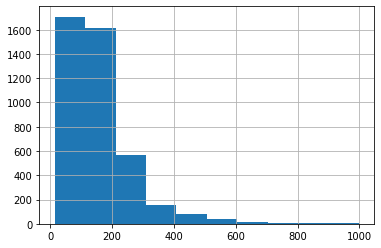

In [15]:
data.Price.hist()

I thought the higher number of bedrooms would dictate the price of lodging, but it turns out that when we separate the data by number of bedrooms only, the prices are still around $450 and lower, with a few higher priced lodgins for each bedroom count.

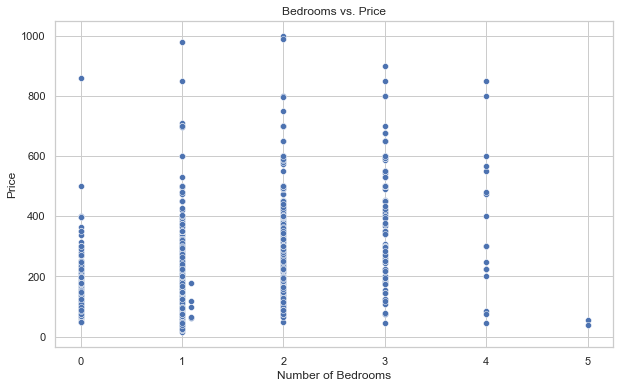

In [26]:

sns.set(style="whitegrid")

# Scatter plot of Bedrooms vs. Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Bedrooms', y='Price', data=data)
plt.title('Bedrooms vs. Price')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price')
plt.show()

Let's plot the correlation between the numerical variables we have available in relation to price. This will give us a good sense of which variables are strongly correlated with price, whether it is positive correlation or negative. We'll ignore the correlation between Latitude Longitude and Price, as our code has misinterpreted these coordinates as actual numbers. I will explore different ways to group the coordinates and observe price differences between each sub-area in NYC later. Our correlation findings show that there is a relatively strong correlation between Price and the following variables: Accomodates, Bathrooms, Bedrooms, and CleaningFee. All of these variables tell me that the more bathrooms/bedrooms and people you can accomodate, the higher the price since the lodging is probably large. A higher CleaningFee tells me that the lodging takes a lot of effort to clean up, since it is large or higher quality. We will develop features based on these variables! But let us explore some more features that may influence Price.

/var/folders/y8/wdtcg25s2w5_6hdbn1bqk9qc0000gn/T/ipykernel_27563/3983333476.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


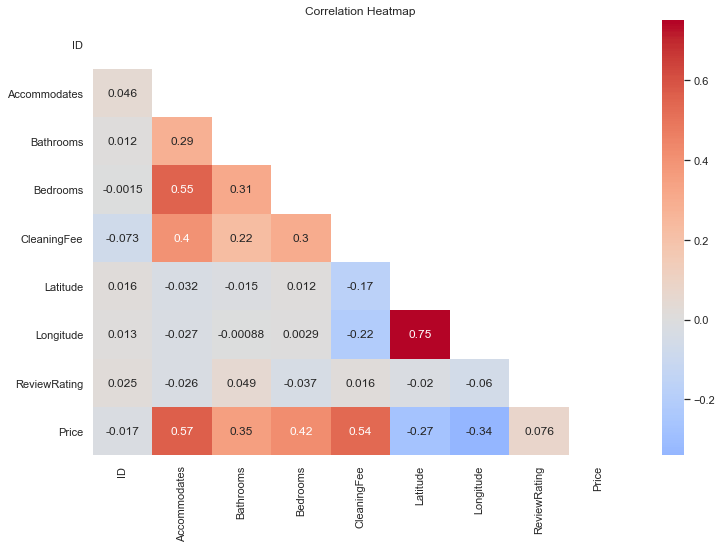

In [29]:
# Correlation heatmap
correlation_matrix = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


In [5]:
data.CancellationPolicy.value_counts()

strict      2277
moderate     993
flexible     931
Name: CancellationPolicy, dtype: int64

We see that a lot of the lodgings have a strict cancellation policy associated with the lodging. I wonder if the Cancellation policy type is distributed differently among the 3 types of policies. The blue bars indicate a strict policy, the orange bar indicated a moderate policy, and the green bar indicates a flexible policy. It looks like the prices of lodging by cancellation policy type is distributed the same among the 3 cancellation policies. <br> <br>

On the graph to your right (below), I created boxplots of the top 10 frequent neighborhoods in our dataset, and observed the distribution of price. The box indicates where 50% of the data ranges from. Certain neighborhoods like Harlem and Washington Heights have their pricings distributed lower than more affluent areas such as Chelsea or Midtown. This has given me inspiration to compute a feature that calculates the average price of a lodging based on the neighborhood it is in, which is a much more specific level of geography than District. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


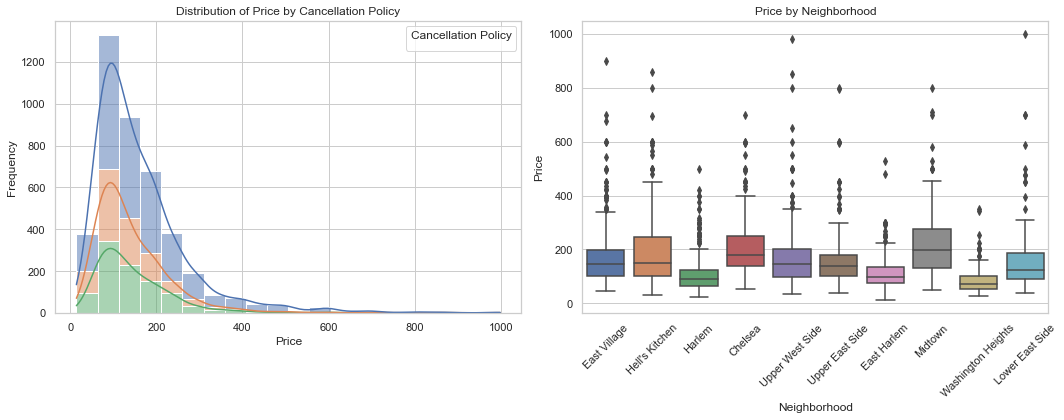

In [8]:
# Set the style for the visualization
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot 1: Histogram of Price with colors representing Cancellation Policy
sns.histplot(data, x='Price', bins=20, kde=True, hue='CancellationPolicy', multiple='stack', ax=axes[0])
axes[0].set_title('Distribution of Price by Cancellation Policy')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')
axes[0].legend(title='Cancellation Policy')

# Plot 2: Box plot for Price by Neighborhood
top_neighborhoods = data['Neighborhood'].value_counts().head(10).index
sns.boxplot(x='Neighborhood', y='Price', data=data[data['Neighborhood'].isin(top_neighborhoods)], ax=axes[1])
axes[1].set_title('Price by Neighborhood')
axes[1].set_xlabel('Neighborhood')
axes[1].set_ylabel('Price')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

Looking below, the left graph shows that the distribution of price does not vary as much by PropertyType. Of course condominiums have a higher range of prices, but since each of the boxplots for each property type are around the same price i.e. around the same y-axis mark, we can say that segmenting the lodgings solely on PropertyType is not a good enough of an indicator to predict differences in pricing. We shall explore the Room Types next. <br> <br> 
We have an interesting finding here on the graph on the right. The box that is plotted for an Entire home/apt is placed much higher on the y-axis (the price scale) than Private rooms and shared rooms. This tells us that lodgings where the entire place is available tend to have higher prices! I've taken note of this and will compute average prices of a lodging based on room type as well as the neighborhood that the lodging is in. From a statistical standpoint, the average price of an entire home/apt (depicted by the black line in the middle of the blue box) is much higher than a majority of the price distribution of private and shared rooms, given us statistical significance regarding the differences in price by room type. 

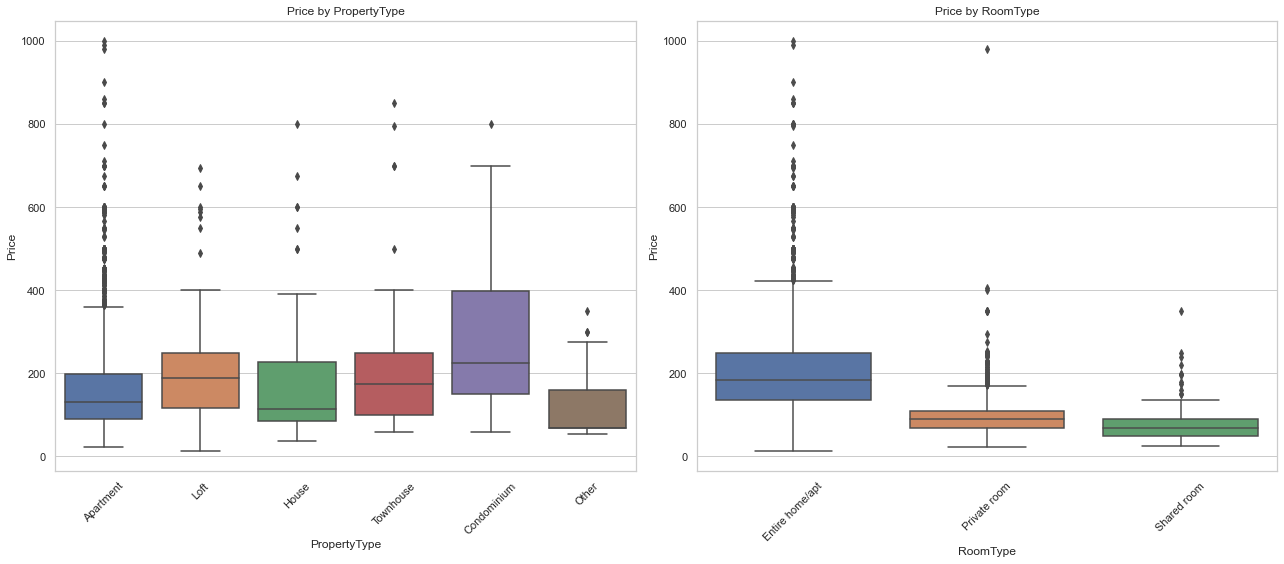

In [9]:
# Get the top 6 property types by counts
top_PropertyType = data['PropertyType'].value_counts().head(6).index

# Get the top Room Types by counts
top_RoomType = data['RoomType'].value_counts().index

# Set the style for the visualization
sns.set(style="whitegrid")

# Create subplots with two plots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Price by PropertyType
sns.boxplot(x='PropertyType', y='Price', data=data[data['PropertyType'].isin(top_PropertyType)], ax=axes[0])
axes[0].set_title('Price by PropertyType')
axes[0].set_xlabel('PropertyType')
axes[0].set_ylabel('Price')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Price by RoomType
sns.boxplot(x='RoomType', y='Price', data=data[data['RoomType'].isin(top_RoomType)], ax=axes[1])
axes[1].set_title('Price by RoomType')
axes[1].set_xlabel('RoomType')
axes[1].set_ylabel('Price')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

The training data did give us geographical dimensions such as neighborhood, but I'm wondering if I can cluster the lodgings myself given the latitude and longitude coordinates. I am going to visualize them to see how well they are grouped, and depict them on a map below. To summarize, we did do a good job of clustering the lodgings by coordinate points. What I am going to do with these clusters is the following: for each lodging, I will determine what cluster they belong to, and compute the average price of a lodging in that cluster. This can give us a more specific average price from the perspective of geographic location. See the clusters build below. The code takes 1-2 mins to run. What you are looking at is Manhattan, with Queens on the left side, and Brooklyn on the upper left side (I could not rotate the map)

In [206]:
# Takes a 1-2 mins to deermine clusters
clf = KMeansConstrained(
    n_clusters=20,
    size_min=28,
    size_max=300,
    random_state=0
)

features = data[['Latitude', 'Longitude']]
clusters = np.array(features)
clf.fit_predict(clusters)
# save results
labels = clf.labels_
# send back into dataframe and display it
data['clusters'] = labels


colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', \
     'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', \
     'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', \
     'black', 'lightgray', 'red', 'blue', 'green', 'purple', \
     'orange', 'darkred', 'lightred', 'beige', 'darkblue', \
     'darkgreen', 'cadetblue', 'darkpurple','pink', 'lightblue', \
     'lightgreen', 'gray', 'black', 'lightgray' ]
lat = data.iloc[0]['Latitude']
lng = data.iloc[0]['Longitude']
map = folium.Map(location=[lng, lat], zoom_start=10)
for _, row in data.iterrows():
    folium.CircleMarker(
        location=[row["Longitude"], row["Latitude"]],
        radius=5, 
        weight=2, 
        fill=True, 
        fill_color=colors[int(row["clusters"])],
        color=colors[int(row["clusters"])]
    ).add_to(map)
map

## Visualization, Modeling, Machine Learning

Can you build a model that can evaluate the lodging and propose a fair price for a night dependent on the given features? Please explain your findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.

- **Build an optimized model that effectively solves the business problem.**
- **Read the test.csv file and prepare features for testing.**

The objective is to propose a FAIR price for a night dependent on the features we have available. With that said, we want to generate a price for a lodging that seems fair relative to the location it is in, the property type, room type, and more. We have seen some differences in price based on factors such as room type and neighborhood. We also learned earlier that we see a correlation between variables related to size, like 'Accommodates', 'Bedrooms' and 'Bathrooms' and price. With that said, what we're going to do is generate signals that influence price, given the analysis we have done above. <br> <br>
Then, we will go ahead and experiment with a few models to see how well we can predict price on the training data we have. Here are some features I will create based on my findings in the section above: <br><br>
* Computed Features:<br>
    * Accommodates to Bedrooms Ratio: A high value would indicate that many people would need to share a bedroom. The assumption is that a lodging with lower ratio would be higher priced, since there is more space per person <br>
    * Accommodates to Bathroom Ratio: A high value would indicate that many people would need to share bathrooms. The assumption is that a lodging with lower ratio would be higher priced, since there are more bathrooms per person<br>
    * Average lodging price based on cluster: I attempted to group the lodgings even more granularly than neighborhood, and computed the average lodging price in an attempt to account for sub market conditions.<br>
    * Average lodging price based on property type and room type: I created this feature to account for the average price of a particular room type, of a particular property.<br>
    * Average lodging price based on neighborhood and room type: I created this feature to also account for sub market conditions (like the cluster average price), using the attributes already given in the dataset<br>
    * Total number of bedrooms + bathrooms: Assumption is that more bedrooms and bathrooms will have a higher priced lodging, since people value having space<br>
* Features that already existed within dataset:<br>
    * RoomType (Encoded)<br>
    * PropertyType (Encoded)<br>
    * Cancellation Policy (Encoded)<br>
    * Cleaning Fee<br>
    * Accommodates<br>
    * Bedrooms<br>
    * Bathrooms<br>
    * ReviewRating<br>


### Data Preparation and Feature Engineering
Below you will see the functions I've created that process our data and compute the features to predict lodging price. Comments on each function is included in the function below.

In [10]:
def create_accommodation_ratios(data):
    """ 
    Input: A DataFrame data containing accommodation information.
    Output: The DataFrame data with two additional columns: 'Accommodates_to_Bedrooms_Ratio' and 'Accommodates_to_Bathrooms_Ratio'.
    """
    # Accommodates to Bedrooms Ratio
    data['Accommodates_to_Bedrooms_Ratio'] = data['Accommodates'] / data['Bedrooms']

    # Accommodates to Bathrooms Ratio
    data['Accommodates_to_Bathrooms_Ratio'] = data['Accommodates'] / data['Bathrooms']
    return data

def encode_roomtype(data):
    """ 
    Input: A DataFrame data containing room type information.
    Output: The DataFrame data with additional columns for one-hot encoded room types. 
    One-hot encoding converts categorical variables, such as room types, into binary columns for each unique category. 
    Each row will have a value of 1 in the corresponding room type column, indicating the presence of that room type, and 0 in other room type columns.
    """
    # One-hot encoding for RoomType
    room_type_encoder = OneHotEncoder(sparse=False)
    room_type_encoded = room_type_encoder.fit_transform(data[['RoomType']])
    room_type_encoded_df = pd.DataFrame(room_type_encoded, columns=room_type_encoder.get_feature_names(['RoomType']))
    data = pd.concat([data, room_type_encoded_df], axis=1)
    return data

def encode_propertytype(data):
    """ 
    Input: A DataFrame data containing property type information.
    Output: The DataFrame data with additional columns for one-hot encoded property types. 
    Similar to one-hot encoding for room types, this function creates binary columns for each unique property type, where a value of 1 in a column indicates the presence of that property type,
    and 0 in other property type columns. I only encode the top 5 property types and group the less frequent property types as 'other'.
    """
    top_property_types = ['Apartment', 'House', 'Loft', 'Condominium', 'Townhouse']

    # List of top 5 PropertyType values
    data['PropertyType_Apartment'] = data['PropertyType'].apply(lambda x: 1 if x == 'Apartment' else 0)
    data['PropertyType_House'] = data['PropertyType'].apply(lambda x: 1 if x == 'House' else 0)
    data['PropertyType_Loft'] = data['PropertyType'].apply(lambda x: 1 if x == 'Loft' else 0)
    data['PropertyType_Condominium'] = data['PropertyType'].apply(lambda x: 1 if x == 'Condominium' else 0)
    data['PropertyType_Townhouse'] = data['PropertyType'].apply(lambda x: 1 if x == 'Townhouse' else 0)
    # Create 'PropertyType_other' column
    data['PropertyType_other'] = data['PropertyType'].apply(lambda x: 1 if x not in top_property_types else 0)
    return data


def encode_cancellationpolicy(data):
    """  
    Input: A DataFrame data containing cancellation policy information.
    Output: The DataFrame data with additional columns for one-hot encoded cancellation policies. 
    This function applies the same one-hot encoding technique to create binary columns for each unique cancellation policy, 
    where a value of 1 in a column indicates the presence of that cancellation policy, and 0 in other cancellation policy columns.
    """
    # One-hot encoding for CancellationPolicy
    cancellation_policy_encoder = OneHotEncoder(sparse=False)
    cancellation_policy_encoded = cancellation_policy_encoder.fit_transform(data[['CancellationPolicy']])
    cancellation_policy_encoded_df = pd.DataFrame(cancellation_policy_encoded, columns=cancellation_policy_encoder.get_feature_names(['CancellationPolicy']))
    data = pd.concat([data, cancellation_policy_encoded_df], axis=1)
    return data

# Geospatial feature using Latitude and Longitude (clustering)
# We will create avg price by the cluster of lat/long coordinates
clf = KMeansConstrained(
    n_clusters=20,
    size_min=28,
    size_max=300,
    random_state=0
)

def cluster_latlong_coordinates(data, clf):
    """  
    Input: A DataFrame data containing latitude and longitude coordinates, and a clustering model clf. The number of clusters was determined by intuition on how many distinct areas in NYC we can group by
    Output: The DataFrame data with an additional 'clusters' column representing the cluster labels assigned to each record.
    """
    coords = data[['Latitude', 'Longitude']]
    clusters = np.array(coords)
    clf.fit_predict(clusters)
    # save results
    labels = clf.labels_
    # send back into dataframe and display it
    data['clusters'] = labels
    return data

def compute_avg_price_by_cluster(data):
    """ 
    Input: A DataFrame data with clustering information.
    Output: The DataFrame data with an additional 'AvgPrice_by_Cluster' column containing the average price within each cluster.
    """
    # Average Price for a given PropertyType and RoomType
    average_price_by_type = data.groupby(['clusters'])['Price'].mean().reset_index()
    average_price_by_type.rename(columns={'Price': 'AvgPrice_by_Cluster'}, inplace=True)
    data = pd.merge(data, average_price_by_type, on=['clusters'], how='left')
    return data

def compute_avg_prices_property_room(data):
    """  
    Input: A DataFrame data containing property and room type information.
    Output: The DataFrame data with an additional 'AvgPrice_by_Type' column containing the average price for each property and room type combination.
    """
    # Average Price for a given PropertyType and RoomType
    average_price_by_type = data.groupby(['PropertyType', 'RoomType'])['Price'].mean().reset_index()
    average_price_by_type.rename(columns={'Price': 'AvgPrice_by_Type'}, inplace=True)
    data = pd.merge(data, average_price_by_type, on=['PropertyType', 'RoomType'], how='left')
    return data

def compute_avg_prices_neighborhood_room(data):
    """ 
    Input: A DataFrame data containing neighborhood and room type information.
    Output: The DataFrame data with an additional 'AvgPrice_by_NeighborhoodRoomType' column containing the average price for each neighborhood and room type combination.
    """
    # Average Price for a given Neighborhood and RoomType
    average_price_by_type = data.groupby(['Neighborhood', 'RoomType'])['Price'].mean().reset_index()
    average_price_by_type.rename(columns={'Price': 'AvgPrice_by_NeighborhoodRoomType'}, inplace=True)
    data = pd.merge(data, average_price_by_type, on=['Neighborhood', 'RoomType'], how='left')
    return data

def add_total_rooms(data):
    """ 
    Input: A DataFrame data containing bedroom and bathroom information.
    Output: The DataFrame data with an additional 'Total_Rooms' column representing the sum of bedrooms and bathrooms.
    """
    # Total number of rooms: Bedrooms + Bathrooms
    data['Total_Rooms'] = data['Bedrooms'] + data['Bathrooms']
    return data

def clean_up_infinite_null_features(data):
    """
    Input: A DataFrame data with potentially infinite and null values.
    Output: The DataFrame data with cleaned 'Accommodates_to_Bedrooms_Ratio' and 'Accommodates_to_Bathrooms_Ratio' columns, replacing infinite values with 0.
    """
    # Replace infinite values in Accommodates_to_Bedrooms_Ratio with 0
    data['Accommodates_to_Bedrooms_Ratio'] = data['Accommodates_to_Bedrooms_Ratio'].replace([np.inf, -np.inf], 0)

    # Replace infinite values in Accommodates_to_Bathrooms_Ratio with 0
    data['Accommodates_to_Bathrooms_Ratio'] = data['Accommodates_to_Bathrooms_Ratio'].replace([np.inf, -np.inf], 0)
    return data


In [11]:
# Add Features
def create_features(data, test_data, mode='training'):
    """ 
    Input: Training or Testing data, with 'mode' indicating if the data is training data or testing data
    Output: The computed features needed to train and predict for our models
    Note: Since we cannot compute average prices in our testing data, we append the historical average prices derived from our training set
    """
    if mode == 'training':
        data = create_accommodation_ratios(data)
        data = encode_roomtype(data)
        data = encode_cancellationpolicy(data)
        data = cluster_latlong_coordinates(data, clf)
        data = compute_avg_price_by_cluster(data)
        data = compute_avg_prices_property_room(data)
        data = compute_avg_prices_neighborhood_room(data)
        data = encode_propertytype(data)
        data = add_total_rooms(data)
        data = clean_up_infinite_null_features(data)
        return data
    else: # if it is for testing, where we do not have the target variable 'Price'
        test_data = create_accommodation_ratios(test_data)
        test_data = encode_roomtype(test_data)
        test_data = encode_propertytype(test_data)
        test_data = encode_cancellationpolicy(test_data)
        test_data = cluster_latlong_coordinates(test_data, clf)
        test_data = add_total_rooms(test_data)
        test_data = clean_up_infinite_null_features(test_data)
        
        # Add historical average prices learned from training
        historical_cluster_prices = data[['clusters', 'AvgPrice_by_Cluster']].drop_duplicates()
        historical_propertyroom_prices = data[['PropertyType', 'RoomType', 'AvgPrice_by_Type']].drop_duplicates()
        historical_neighborhoodroom_prices = data[['Neighborhood', 'RoomType', 'AvgPrice_by_NeighborhoodRoomType']].drop_duplicates()

        test_data = pd.merge(test_data, historical_cluster_prices[['clusters', 'AvgPrice_by_Cluster']], on=['clusters'], how='left')
        test_data = pd.merge(test_data, historical_propertyroom_prices[['PropertyType', 'RoomType', 'AvgPrice_by_Type']], on=['PropertyType', 'RoomType'], how='left')
        test_data = pd.merge(test_data, historical_neighborhoodroom_prices[['Neighborhood', 'RoomType', 'AvgPrice_by_NeighborhoodRoomType']], on=['Neighborhood', 'RoomType'], how='left')

        # If we see new neighborhoods or areas that we did not have information available for in testing data, let's impute these values with 
        # Impute null values where we do not have historical prices, we use the cluster price since we have this data guaranteed to be available (unless we have a lodging outside of NYC)
        test_data['AvgPrice_by_Type'] = np.where(
            test_data['AvgPrice_by_Type'].isnull(),
            test_data['AvgPrice_by_Cluster'],
            test_data['AvgPrice_by_Type']
        )

        # Replace null values in 'AvgPrice_by_NeighborhoodRoomType' with values from 'AvgPrice_by_Cluster'
        test_data['AvgPrice_by_NeighborhoodRoomType'] = np.where(
            test_data['AvgPrice_by_NeighborhoodRoomType'].isnull(),
            test_data['AvgPrice_by_Cluster'],
            test_data['AvgPrice_by_NeighborhoodRoomType']
        )
        return test_data


In [12]:
data = create_features(data, None, mode='training')

### Split Training Samples into Training and Validation Data
Now that we've created some good signals, we're going to move forward with experimenting with a few models. Since we cannot evaluate the predicted prices on our testing data (because we do not have that information), the best we can do is hold out some training data and treat this as our validation. We will do a 70%-30% split between training and validation data. This number can always be tuned to observe different model performances.

In [14]:
# Create Training Set for the undersampled dataset

# Separate the Predictors from the Target variable we are trying to predict
X = data.loc[:,data.columns != 'Price']
y = data.loc[:,data.columns == 'Price']

# Drop the categorical columns since we've encoded them into a numerical representation
categorical_cols = ['ID', 'District', 'PropertyType', 'Neighborhood', 'CancellationPolicy', 'RoomType']
X = X.drop(categorical_cols, axis=1)

# Handling missing values with imputation
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Handling very large values with feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Checking for infinity or very large values
if not np.isfinite(X_scaled).all():
    raise ValueError("Input data contains infinity or very large values.")


# Now, split scaled and imputed data
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

## Modelling Attempt 1: Using Linear Regression
A good practice is always to use a simpler model where it makes sense. This is what we'll do. We'll experiment with a Linear Regression model, which assumes that the features have a linear relationship with Price. We'll take a look at the performance of this model on our validation dataset, and also check if the assumptions of Linear Regression are satisfied such as homoskedasticity (constnt variance in the errors).

In [19]:
# create linear regression object
reg = linear_model.LinearRegression()
 
# train the model using the training sets
reg.fit(X_train_scaled, y_train)
 
# regression coefficients
print('Coefficients: ', reg.coef_)
 
# variance score: How much of the variance in Y is explained in the variance in our X data?
print('Variance score: {}'.format(reg.score(X_val_scaled, y_val)))

y_pred = reg.predict(X_val_scaled).flatten()


Coefficients:  [[ 7.53922500e+01  6.33507043e+12  1.33066992e+13  1.80293752e+01
   7.83720591e-01 -6.12961832e+00  5.07864669e+00 -4.39503706e+00
  -4.90433555e+01 -8.97035532e+13 -8.88204414e+13 -3.05249684e+13
  -4.24835011e+13 -4.34573648e+13 -5.09630759e+13  2.04234982e-02
   3.28739752e+00  3.02253418e+01  4.72846680e+01 -8.03656010e+13
  -4.11520016e+13 -3.71673413e+13 -3.47919697e+13 -3.26750404e+13
  -3.75479839e+13 -1.64320711e+13]]
Variance score: 0.5775293294062407


The variance score answers the question 'How much variance in Price is accounted for from the Predictors we have created?' and the results are abysmal. With that said, this model cannot explain the variations in price. This could be for numerous reasons - Linear Regression may not be the best model to fit on our data, as we neglect to capture non-linear relationships. Or, the assumptions of Linear Regression are not satisfied, thus providing us an inflated value. Let's observe the Mean Absolute Percentage Error:

In [20]:
combined = np.column_stack((y_pred.flatten(), np.array(y_val).flatten()))
# Calculate MAPE
mape = np.mean(np.abs((combined[:, 1] - combined[:, 0]) / combined[:, 1])) * 100

# Print MAPE
print("Mean Absolute Percentage Error (MAPE): %.3f" % mape)

Mean Absolute Percentage Error (MAPE): 29.994


This MAPE is 29.99% A lower MAPE indicates that the model's predictions are close to the actual price values on average. In other words, a lower MAPE suggests a more accurate model. A higher MAPE indicates that the model's predictions have a larger percentage difference from the actual values. A higher MAPE suggests less accuracy. Let's plot the Actual vs Predicted values below from our Linear Regression model:

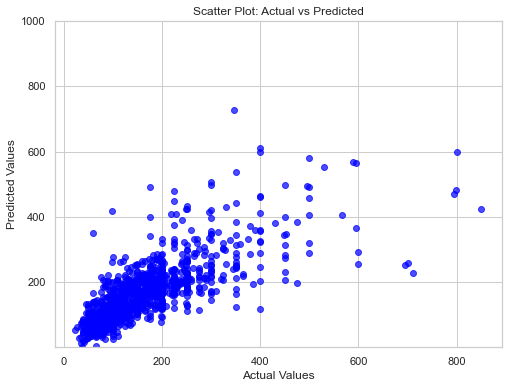

In [23]:
actuals = combined[:, 1]
preds = combined[:, 0]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(actuals, preds, color='blue', alpha=0.7)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot: Actual vs Predicted")
# Set y-axis limits to match the range of the data
y_max = 1000
y_min = min(np.min(preds), np.min(actuals))
plt.ylim(y_min, y_max)
plt.grid(True)
plt.show()

We expected to see the points plotted along the y=x axis i.e. a diagonal line going from 0 all the way up to the top right of the plot. This would tell us that the predicted value is similar to the actual price value. Since the points end up scattering as we make our way to the top right of the graph, we conclude that the Linear Regression model did a decent job with lower priced lodgings, but had inaccurate results with higher priced lodgings. This is equivalent to plotting the Residual Values versus Actual Price below. In the Residuals vs Actuals plot below, we expect to see the Residual value (Actual - Predicted Price) to be along the blue line where y=0. Y=0 means that the residual value is 0, meaning there is no difference between the predicted value and actual value. Unfortunately that is not the case. Additionally, our assumption on the errors of Linear Regression are not satisfied, since the errors are not consistent across the Actual Price values - we see the errors scattering outwards as the actual price increases Technically, this violated the homoskedasticity assumption of Linear Regression.

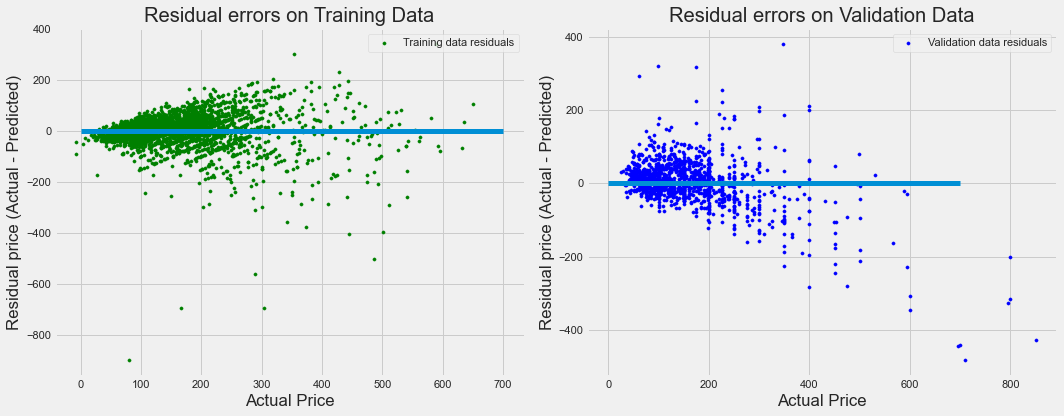

In [24]:
# Set the style for the plots
plt.style.use('fivethirtyeight')

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting residual errors in training data
axs[0].scatter(reg.predict(X_train_scaled),
               reg.predict(X_train_scaled) - y_train,
               color="green", s=10,
               label='Training data residuals')
axs[0].hlines(y=0, xmin=0, xmax=700, linewidth=5)  # Line for zero residual error
axs[0].legend(loc='upper right')
axs[0].set_title("Residual errors on Training Data")
axs[0].set_xlabel('Actual Price')
axs[0].set_ylabel('Residual price (Actual - Predicted)')

# Plotting residual errors in validation data
axs[1].scatter(actuals,
               preds - actuals,
               color="blue", s=10,
               label='Validation data residuals')
axs[1].hlines(y=0, xmin=0, xmax=700, linewidth=5)  # Line for zero residual error
axs[1].legend(loc='upper right')
axs[1].set_title("Residual errors on Validation Data")
axs[1].set_xlabel('Actual Price')
axs[1].set_ylabel('Residual price (Actual - Predicted)')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

## Modelling Attempt 2: Using XGBoost
A good practice is always to use a simpler model where it makes sense. However, given the performance of our Linear Regression model and the violation of our assumptions, we will try a commonly used algorithm called XGBoost. XGBoost utilizes Decision Trees as a team of little robots. Each robot is good at making a simple guess, but they're not perfect. They might guess a bit too high or too low. However, they work together to fix each other's mistakes. When one robot makes a mistake, the next robot tries to correct it. They keep passing the guess and mistake to each other until they collectively get really close to the right answer.

In XGBoost, these robots are like small models, and they're trained to make better guesses over time. They learn from their previous mistakes and become better at predicting. This teamwork of models, each correcting the other's errors, makes XGBoost a really accurate tool for predicting things. It's like having a bunch of friends who are good at different things and help each other out to solve a puzzle.

In [25]:
#XGB
start_time = time.time()
print("~~~~~XGB~~~~~")
# Split the data for validation

print("Model fitting...")
xgb_model = XGBRegressor(n_estimators=50, random_state=497, 
                            max_depth=10, 
                            eval_metric='mape', learning_rate=0.1,
                           max_leaves = 100)

xgb_model.fit(X_train_scaled, y_train)

print("Validation prediction...")
xgb_validation_predictions = xgb_model.predict(X_val_scaled)

# Calculate MAPE
mape_xgb = mean_absolute_percentage_error(y_val, xgb_validation_predictions)

# Print MAPE
print("Mean Absolute Percentage Error (MAPE): %.3f" % (mape_xgb*100))
end_time = time.time()

print("Runtime on training data: %.3f" % (end_time - start_time))

~~~~~XGB~~~~~
Model fitting...
Validation prediction...
Mean Absolute Percentage Error (MAPE): 28.074
Runtime on training data: 0.378


#### We are able to achieve a lower MAPE value (28.07%) using XGBoost for Regression! The other benefits of XGBoost include: interpretability, and predicting at scale. But first, I will try and optimize the hyperparameters for the XGBoost model so that we have the right parameters passed to our model for the learning task of predicting prices.

In [276]:
# XGB has a MAPE of 28.215 which is an improvement from 29.967 from Linear Regression
# linear Regression Residual assuptions are not satisfied (Heteroskedasticity)
# Features were not shown to have just a linear relationship, we want to capture non-linear relationships as well

### A quick Hyperparameter Optimization

In [26]:
# Optimize the XGBoost model. HyperOpt had some bugs so we will move forward by manually optimizing
# Define the hyperparameter space
n_estimators_values = [50, 100, 500]
max_depth_values = [5, 10, 15, 20]
learning_rate_values = [0.01, 0.05, 0.1]

# Perform manual optimization using nested loops
best_mape = float('inf')
best_hyperparams = {}

for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for learning_rate in learning_rate_values:
            model = XGBRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 learning_rate=learning_rate,
                                 eval_metric='mape', max_leaves = 100,
                                 random_state=497)
            
            model.fit(X_train_scaled, y_train)
            preds = model.predict(X_val_scaled)
            mape = mean_absolute_percentage_error(y_val, xgb_validation_predictions)
            #print("The MAPE is ", mape*100)
            #print("n estimators: ", n_estimators)
            #print("max_depth: ", max_depth)
            #print("learning rate is: ", learning_rate)
            if mape < best_mape:
                best_mape = mape
                best_hyperparams = {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'learning_rate': learning_rate
                }

print("Best hyperparameters:", best_hyperparams)
print("Best MAPE:", best_mape*100)

Best hyperparameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01}
Best MAPE: 28.073800851204084


Now that we have determined the optimal hyperparameters for our XGboost model, let us re-create the model with these hyperparameters, and then continue onto testing!

In [27]:
# Now train the best XGBoost Model using the hyperparameters and observe MAPE
# Then plot feature importance
#XGB
start_time = time.time()
print("~~~~~XGB after Optimizing Hyperparameters~~~~~")
# Split the data for validation

print("Model fitting...")
xgb_model = XGBRegressor(n_estimators=50, random_state=497, 
                            max_depth=5, 
                            eval_metric='mape', learning_rate=0.1,
                           max_leaves = 100)

xgb_model.fit(X_train_scaled, y_train)

print("Validation prediction...")
xgb_validation_predictions = xgb_model.predict(X_val_scaled)

# Calculate MAPE
mape_xgb = mean_absolute_percentage_error(y_val, xgb_validation_predictions)

# Print MAPE
print("Mean Absolute Percentage Error (MAPE): %.3f" % (mape_xgb*100))
end_time = time.time()

print("Runtime on training data: %.3f" % (end_time - start_time))

~~~~~XGB after Optimizing Hyperparameters~~~~~
Model fitting...
Validation prediction...
Mean Absolute Percentage Error (MAPE): 27.621
Runtime on training data: 0.219




**The management wants to know what are the most important features for your model & model performance.  Can you tell them?**

> #### Task:
- **Visualize the top 10 features and their feature importance.**<br> <br>
XGBoost has a neat tool that allows us to visualize the top 10 powerful features for our model, optimized for MAPE. The Feature Importance value is usually expressed as a percentage or a score. A higher value means that the feature has a stronger impact on the model's predictions, while a lower value means that the feature has a relatively weaker impact. For example, if a feature has a high Feature Importance value of 0.15, it suggests that this feature explains about 15% of the variability in the target variable. On the other hand, if a feature has a low value of 0.02, it might only explain around 2% of the variability. <br> <br> 
- **Show model preformance using mean absolute percent error as your performance metric.**


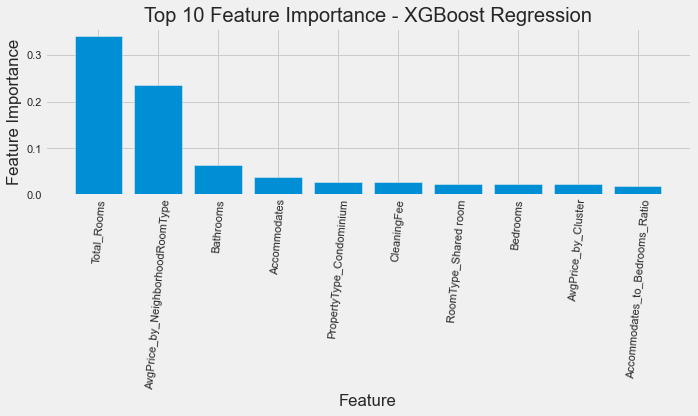

In [28]:
# Get feature importance values
feature_importance = xgb_model.feature_importances_

# Get the feature names from your DataFrame or X_train_scaled
feature_names = X.columns

# Sort feature importance values in descending order
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Select the top 10 features
top_n = 10
top_sorted_feature_importance = sorted_feature_importance[:top_n]
top_sorted_feature_names = sorted_feature_names[:top_n]

# Create a bar plot for the top 10 feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), top_sorted_feature_importance)
plt.xticks(range(top_n), top_sorted_feature_names, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.xticks(rotation=85)
plt.title("Top 10 Feature Importance - XGBoost Regression")
plt.tight_layout()
plt.show()

In [29]:
# Show Model Performance using MAPE as my performance Metric
# Calculate MAPE
mape_xgb = mean_absolute_percentage_error(y_val, xgb_validation_predictions)

# Print MAPE
print("Mean Absolute Percentage Error (MAPE): %.3f" % (mape_xgb*100))

Mean Absolute Percentage Error (MAPE): 27.621


For lodgings that are under $400, the model predicts a price that is closer in that range, whereas for the more expensive lodgingsthe model tends to predict more conservatively, thus creating a large residual as we go along the x-axis.

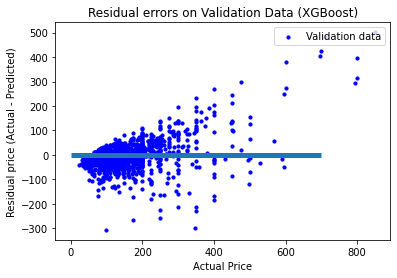

In [85]:
y_pred = xgb_validation_predictions
combined = np.column_stack((y_pred.flatten(), np.array(y_val).flatten()))
plt.ylabel('Residual price (Actual - Predicted)')
plt.xlabel('Actual Price')

# Calculate residuals
residuals = np.array(y_val).flatten() - np.array(xgb_validation_predictions)
y_val_xgb = np.array(y_val).flatten()
# Plotting residual errors in validation data
plt.scatter(y_val_xgb,
            residuals.flatten(),
            color="blue", s=10,
            label='Validation data')

# Plotting line for zero residual error
plt.hlines(y=0, xmin=0, xmax=700, linewidth=5)

# Plotting legend
plt.legend(loc='upper right')

# Plot title
plt.title("Residual errors on Validation Data (XGBoost)")

# Method call for showing the plot
plt.show()

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the test set (`test.csv`), you must predict the value of the `Price` variable. You should submit a CSV file with a header row and one row per test entry. The file (submissions.csv) should have exactly 2 columns:

The file (`submissions.csv`) should have exactly 2 columns:
   - **ID**
   - **Price**

In [40]:
test_data=pd.read_csv('data/test.csv')
test_data.head()

,ID,District,Neighborhood,PropertyType,CancellationPolicy,Accommodates,RoomType,Bathrooms,Bedrooms,CleaningFee,Latitude,Longitude,ReviewRating
0,8760775,Manhattan,Murray Hill,Apartment,flexible,1,Private room,1.0,1.0,63.827637,40.749400,-73.978226,95.0
1,16425551,Manhattan,Chinatown,Apartment,flexible,1,Private room,1.0,1.0,35.000000,40.716220,-73.991230,95.0
2,15043585,Manhattan,Hell's Kitchen,Apartment,flexible,2,Private room,1.0,1.0,63.827637,40.761096,-73.987602,90.0
3,16516930,Manhattan,Gramercy,Apartment,strict,6,Entire home/apt,1.0,3.0,150.000000,40.736475,-73.985136,60.0
4,1891017,Manhattan,Chelsea,Apartment,strict,2,Entire home/apt,1.0,0.0,69.000000,40.750661,-74.003774,96.0


In [41]:
# Add Features
test_data = create_features(data, test_data, mode='testing')

In [34]:
categorical_cols = ['ID', 'District', 'Neighborhood', 'PropertyType', 'CancellationPolicy', 'RoomType']
X_test = test_data.drop(categorical_cols, axis=1)

# Handling missing values with imputation
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_test)

# Handling very large values with feature scaling
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Checking for infinity or very large values
if not np.isfinite(X_test_scaled).all():
    raise ValueError("Input data contains infinity or very large values.")


In [35]:
# Generate predictions on test set
xgb_test_predictions = xgb_model.predict(X_test_scaled)

In [36]:
# Create a new dataframe with 'ID' and 'preds' as columns
result_df = pd.DataFrame({'ID': test_data['ID'], 'Price': xgb_test_predictions})


In [37]:
result_df

,ID,Price
0,8760775,179.126572
1,16425551,200.507065
2,15043585,185.695297
3,16516930,225.225830
4,1891017,98.907013
...,...,...
1395,7480729,113.448120
1396,13315940,137.096649
1397,15896274,253.428345
1398,7529908,111.121353


In [38]:
#Submission
result_df.to_csv('data/submissions.csv',index=False)

## Future Work

If I had more data, I would try collecting historical bookings made on each of these lodgings along with the timestamps. In this way, we could have created temporal features that account for seasonality or for fluctuating price rates based on time and demand. Additionally, I would look for the number of reviews as well - this will give a better idea of the quality of the lodging, which can affect the pricing. I would also perform a sophisticate grid search of the optimal hyperparameters for the tree model. 

---